### Load libs

In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter


In [2]:
n = 500
pd.set_option('display.max_columns', n)
pd.set_option('display.max_rows', n)
pd.set_option('display.max_colwidth', -1)

/anaconda3/envs/kn/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


### Load data

In [3]:
folder = 'data/test survival/'
file = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
path = folder + file
path

'data/test survival/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
df.head(2)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female  0              Yes     No         1       No            
1  5575-GNVDE  Male    0              No      No         34      Yes           

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service  DSL             No             Yes           
1  No                DSL             Yes            No            

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0  No               No          No          No              Month-to-month   
1  Yes              No          No          No              One year         

  PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges Churn  
0  Yes              Electronic check  29.85           29.85        No    
1  No               Mailed check      56.95           1889.5       No

### Processing

In [6]:
# convert
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )
df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)


In [7]:
cat_cols = [i for i in df.columns if df[i].dtype==object]
cat_cols.remove('customerID')

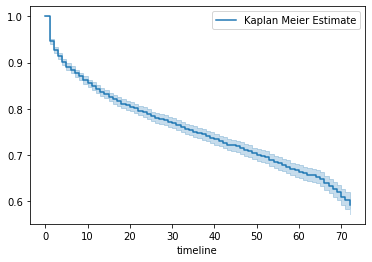

In [8]:
durations = df['tenure']
event_observed = df['Churn'] 

km = KaplanMeierFitter() 
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

km.plot()


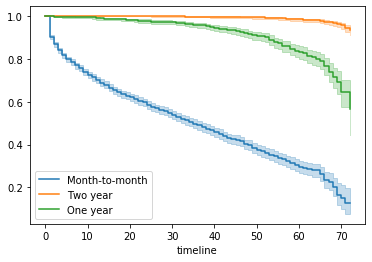

In [9]:
kmf = KaplanMeierFitter() 
T = df['tenure']
E = df['Churn']

groups = df['Contract']
ix1 = (groups == 'Month-to-month')
ix2 = (groups == 'Two year')
ix3 = (groups == 'One year')

kmf.fit(T[ix1], E[ix1], label='Month-to-month')
ax = kmf.plot()

kmf.fit(T[ix2], E[ix2], label='Two year')
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='One year')
kmf.plot(ax=ax1)   

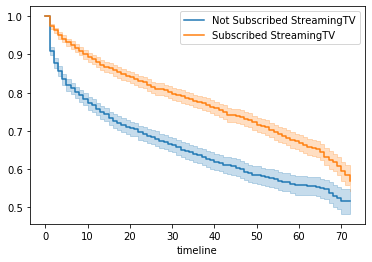

In [10]:
kmf1 = KaplanMeierFitter() 

groups = df['StreamingTV']   
i1 = (groups == 'No') 
i2 = (groups == 'Yes')

kmf1.fit(T[i1], E[i1], label='Not Subscribed StreamingTV')
a1 = kmf1.plot()

kmf1.fit(T[i2], E[i2], label='Subscribed StreamingTV')
kmf1.plot(ax=a1)

In [11]:
df_r= df.loc[:,['tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]
df_r.head() ## have a look at the data

tenure  Churn  gender Partner Dependents PhoneService  MonthlyCharges  \
0  1       0      Female  Yes     No         No           29.85            
1  34      0      Male    No      No         Yes          56.95            
2  2       1      Male    No      No         Yes          53.85            
3  45      0      Male    No      No         No           42.30            
4  2       1      Female  No      No         Yes          70.70            

   SeniorCitizen StreamingTV  
0  0              No          
1  0              No          
2  0              No          
3  0              No          
4  0              No

In [12]:
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

tenure  Churn  MonthlyCharges  SeniorCitizen  gender_Male  Partner_Yes  \
0  1       0      29.85           0              0            1             
1  34      0      56.95           0              1            0             
2  2       1      53.85           0              1            0             
3  45      0      42.30           0              1            0             
4  2       1      70.70           0              0            0             

   Dependents_Yes  PhoneService_Yes  StreamingTV_No internet service  \
0  0               0                 0                                 
1  0               1                 0                                 
2  0               1                 0                                 
3  0               0                 0                                 
4  0               1                 0                                 

   StreamingTV_Yes  
0  0                
1  0                
2  0                
3  0                
4  0

In [14]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'tenure', event_col='Churn')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15182.39
         time fit was run = 2021-01-26 19:25:05 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
MonthlyCharges                   -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
SeniorCitizen                     0.40       1.49       0.06             0.29             0.50                 1.33                 1.66
gender_Male                      -0.01       0.99       0.05            -0.10             0.08                 0.90                 1.08
Partner_Yes                      -0.81       0.45       0.05            -0.92            -0.70                 0.40                 0.50
Dependents_Yes                   -0.36       0.70       0.07            -0.49            -0.22                 0.61                 0.80
PhoneService_Yes                  0.69       2.00       0.10             0.49             0.90                 1.63                 2.45
StreamingTV_No internet service  -2.10       0.12       0.13            -2.36            -1.84                 0.09                 0.16
StreamingTV_Yes                  -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93

                                     z      p   -log2(p)
covariate                                               
MonthlyCharges                   -6.13 <0.005      30.06
SeniorCitizen                     7.16 <0.005      40.15
gender_Male                      -0.23   0.82       0.29
Partner_Yes                     -14.93 <0.005     164.98
Dependents_Yes                   -5.21 <0.005      22.37
PhoneService_Yes                  6.65 <0.005      34.96
StreamingTV_No internet service -15.79 <0.005     184.09
StreamingTV_Yes                  -3.10 <0.005       9.03
---
Concordance = 0.71
Partial AIC = 30380.78
log-likelihood ratio test = 941.30 on 8 df
-log2(p) of ll-ratio test = 654.95

In [15]:
tr_rows = df_dummy.iloc[5:10, 2:]
tr_rows

MonthlyCharges  SeniorCitizen  gender_Male  Partner_Yes  Dependents_Yes  \
5  99.65           0              0            0            0                
6  89.10           0              1            0            1                
7  29.75           0              0            0            0                
8  104.80          0              0            1            0                
9  56.15           0              1            0            1                

   PhoneService_Yes  StreamingTV_No internet service  StreamingTV_Yes  
5  1                 0                                1                
6  1                 0                                1                
7  0                 0                                0                
8  1                 0                                1                
9  1                 0                                0

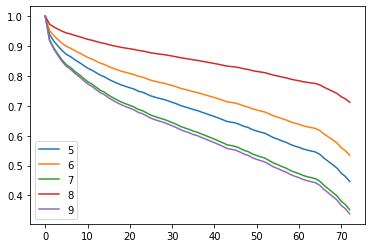

In [16]:
cph.predict_survival_function(tr_rows).plot()
